Notebook Linear Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- data summarizen via summarytools
- missing data oplossen 
- incorrect types controleren
- Numerische waarde standardizeren
- Categorische varaiabelen processen
- Feature engineering
- select features for modelling
- unbalance van de features corrigeren met SMOTE checken
- modeling met Linear Regression, Decision Tree Regression en Random Forrest Regression
- modeling met Hyperparameter tuning met GridSearchCV
- modeling met Optuna voor Hyperparameter tuning



In [21]:
# import van de diverse modules

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance

from sklearn.metrics import classification_report
from sklearn.metrics import  confusion_matrix, accuracy_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

import datetime
from colorama import Fore, Back, Style
import sys
import os
import chardet

In [3]:
# enkele extra code snippets gebruikt doorheen de oefening

plot_graphs = True

# schrijf een visual naar file
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# functies om te loggen naar file
# Lezen van de JSON-file
log_info_lijst = []

def read_JSON(file_path_read):
    with open(file_path_read, 'r') as file:
        files_from_json = json.load(file)
    return files_from_json

def log_info(boodschap):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Style.RESET_ALL}{formatted_date} : INFO : {boodschap}"
    log_info_lijst.append(log_message)
    print(log_message)
    return

def log_error(boodschap):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Fore.RED}{formatted_date} : ERROR : {boodschap}{Style.RESET_ALL}"
    log_info_lijst.append(log_message)
    print(log_message)
    return

def log_warning(boodschap):
    global log_info_lijst
    now = datetime.datetime.now()
    formatted_date = now.strftime("%d/%m/%Y %H:%M:%S")
    log_message = f"{Fore.YELLOW}{formatted_date} : WARNING : {boodschap}{Style.RESET_ALL}"
    log_info_lijst.append(log_message)
    print(log_message)
    return


def log_info_write_to_file(filename):
    with open(filename, 'w') as file:
        for string in log_info_lijst:
            file.write(string + '\n')  # Voeg een nieuwe regel toe na elke string
    return

def log_info_print_on_screen():
    for boodschap in log_info_lijst:
        print(boodschap)    
    return





In [4]:
# data bestand inlezen

insurance_data_filename = 'data/insurance.csv'
df = pd.read_csv(insurance_data_filename)
log_info(f"File {insurance_data_filename}")

06/02/2025 15:36:30 : INFO : File data/insurance.csv


In [5]:
# enkele eenvoudige controles

log_info(f"df.info : \n{df.info()}")
log_info(f"df.describe : \n{df.describe()}")

# geen nulwaarden 

from summarytools import dfSummary
dfSummary(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
06/02/2025 15:36:30 : INFO : df.info : 
None
06/02/2025 15:36:30 : INFO : df.describe : 
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 39.2 (14.0)min < med < max:18.0 < 39.0 < 64.0IQR (CV) : 24.0 (2.8),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACn0lEQVR4nO3cTW7aUBSG4XNLAPMjI4QEMzZQqQOGXkQX2yVkwArYAbNICBnhxsIYd0SlKipg3xL7c99nHNvo6o2xr5LjiqIwoOm+1P0BgEe83PsB59zAzHoVz38qiuK94rHAbzdDdc4NZrPZ9zAMp1VOfjgc9s65H8QKX/fuqL0wDKdRFL1PJpO0zInjOA7W6/V0t9v1zIxQ4eXuV7+Z2WQySefz+c8K5x9UOAb4gJcpSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSHjon/vweTznKJi1dJbCU0PN87xrZqFzruopWrnof+M7R8GsvbMUnhZqkiTdLMu+LZfLTqfTKTUT4Ep10T3uiuF4PJ5HUXQoO0fBrN2zFJ4W6ul0egmCYLhardLFYrEve7zqovvcFbMsC/I8/9rv918rzlEwa+kshac/o45Go6rDK8w0F73ydJntdjvdbDbD8/ncedaHU9Xal6m6X0qqTJfZ7/e1/mLWvWa3tDJUXkrKa/qatTJU8/j6NdN9PvbU6DVra6hm5jXczUzz+dhbU9es1aH+jzz2rsPL5dKt6dpmd55vGx1qnYuuyGfv+ro1lqbpq5mVvqP67pvfe75tbKh1Lroqn71r360xn2s/8nzb2FDrXHQz7bt5lb3rf7U15rFvfvP6jQ31qo5F527ePI0PtQ51383xEaHeUOdXKP7EH05DAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCwkOzp+I4Dsqe+Hg8BmZmSZIEb29vw888XvXaqp/b9/hH+voFxzS0uSGw110AAAAASUVORK5CYII="">",0(0.0%)
2,sex[object],1. male2. female,676 (50.5%)662 (49.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
3,bmi[float64],Mean (sd) : 30.7 (6.1)min < med < max:16.0 < 30.4 < 53.1IQR (CV) : 8.4 (5.0),548 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAClElEQVR4nO3dQY7aMBSA4ecyoABSIkQFOy5QqQuWHKKH7RGKxAm4ATukKAoiJSKEdFexGDEQO4Of5//2AS9+IWxsbJqmEcB33149AOARb68eQFeMMUMRGVi8xLlpmpOr8cBOkKEaY4bT6fRXHMeTtq9xOBwyY8xvYvVDkKGKyCCO48lqtTolSVI++3Ce59Fms5mkaToQEUL1QKihiohIkiTlbDb72/LxodPBwAqTKahAqFCBUKFC0N9RbdR13ReR2BjT5nGWthwj1HcURdGvqurnYrHo9Xq9p1cNWNpyj1DfcT6f36IoGi2Xy3I+n2fPPMvSVjcI9Y7xeNx2eYulLceYTEEFQoUKhAoVCBUqECpUIFSoQKhQwet1VItd+vH1eu27Hg9ex9tQbXbpV1UV1XX9oyzLPyLSdj8qPOJtqGKxS3+320222+3ocrn0uhocPpfPoYpIu136WZbxE2ZgmExBBUKFCoQKFQgVKng/mdKIYyzuEapjHGPpBqE6xjGWbhBqRzjG4haTKahAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQodOfUC3veuIkKf7rLFTbu544SYpbXX6iWt31xElS3Op891Tbu544SYpbTKagAqFCBUKFCuzw94zlwUCRQA8HEqpHbA8GioR7OJBQPWJzMFAk7MOBhOohi4OBIoEeDmQyBRUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoV+GUqMKH+2/WHoXLNox4h/9v13VC55lGXkP/t+qNPVK55VCjEf7t+6Dsq1zx+DT5v2mYyBRHxf9M2oUJE3GzaXq/XszRNvxtjDm2GcC/wh0LN8zx69l2Px2MkIlIURbTf70ef+bzW9/Zh3G2dTqdOVxz+AU+4nv9BXK0JAAAAAElFTkSuQmCC"">",0(0.0%)
4,children[int64],1. 02. 13. 24. 35. 46. 5,574 (42.9%)324 (24.2%)240 (17.9%)157 (11.7%)25 (1.9%)18 (1.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACw0lEQVR4nO3dQU7bUBiF0T9RRJuJowiJZbCALKKL7SKygOwDRXjQUCbpoJTSDoCBfZ9lnzNj9pA+vciRr7K6Xq8FCevWB2A5xEaM2IgRGzGrqtpW1U3rg0zA8/V6vbQ+xJxtbm9vv3Vdt299kNb6vj+vVqvvghvPpuu6/eFwuOx2u6fWh2nl8fHx6/F43D88PNxUldhGsqmq2u12T3d3dz9aH6axbesDzJ0HBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlP1+xWb1gdpaen/f8qm7/vz8Xjc18Jfsen7/lxVz63PMWdeC//La+EjWxkpkzLlm81NMzOTHbwYoMzPJAcvBijzNOXBy6KfjufIl7rEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozY

In [6]:
# twee categorische features: smoking, region en sex
# drie numerische 
# maak de datasets aan 

df_cat_col = ['smoker','region','sex']
df_num_col = ['age', 'bmi','children','charges']
df_label_col = ['charges']

df_cat_nom_col = ['smoker','region']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]

In [7]:
# korte analyze van de categorische variabelen
df_cat.value_counts()

# check op nullen
nul_waarden = df.isnull().sum()
log_info(f"Check op nulwaarden \n{nul_waarden}")
# geen nullen

#check op duplicates
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates \n{duplicate_waarden}")
#  oeps er is er één
# drop it

df.drop_duplicates(inplace=True)
duplicate_waarden = df.duplicated().sum()
log_info(f"Check op duplicates na drop \n{duplicate_waarden}")
log_info_write_to_file('LinReg_logging.log')

06/02/2025 15:36:31 : INFO : Check op nulwaarden 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
06/02/2025 15:36:31 : INFO : Check op duplicates 
1
06/02/2025 15:36:31 : INFO : Check op duplicates na drop 
0


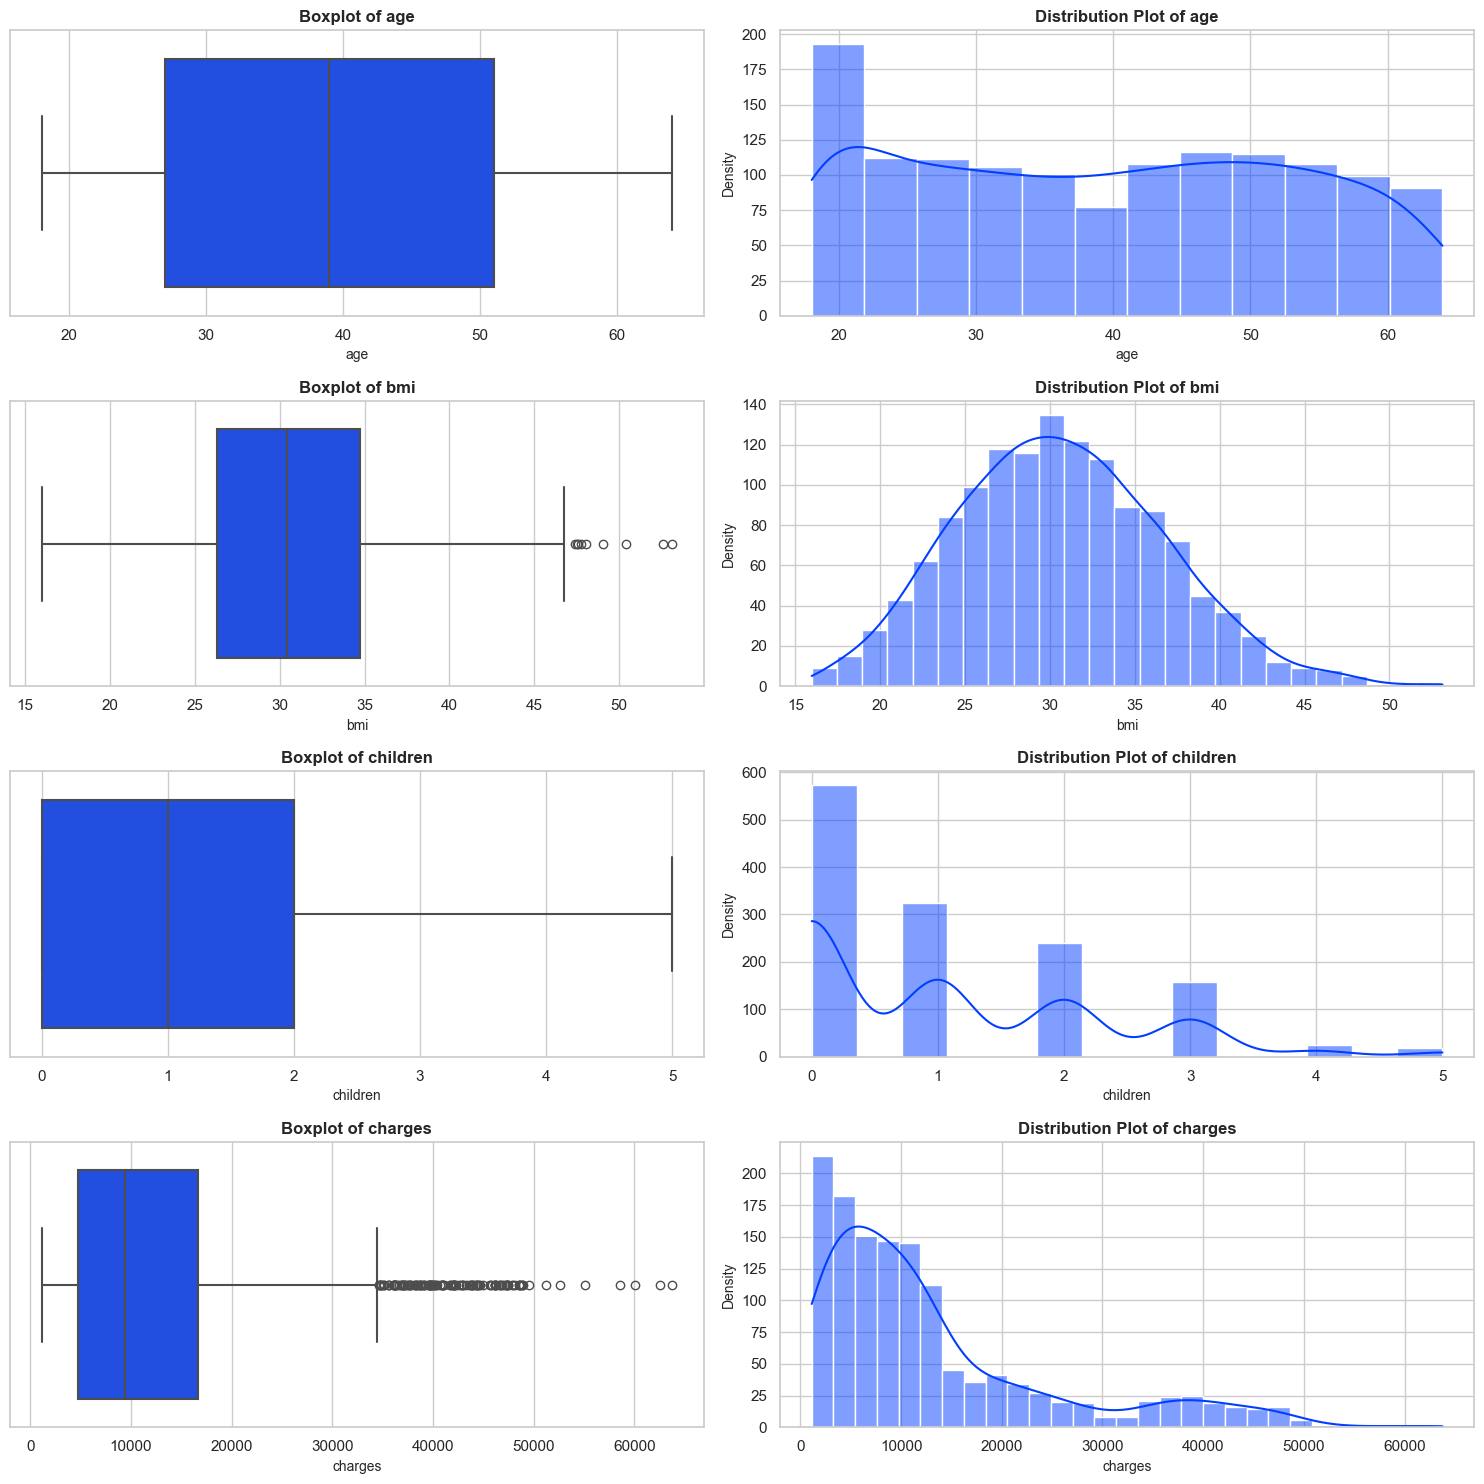

06/02/2025 15:44:04 : INFO : Check van numerische features


In [17]:
# boxplot van de numerische waarden
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, 15)) 
for i, col in enumerate(df_num_col):
    plt.subplot(len(df_num_col), 2, 2 * i + 1)
    sns.boxplot(x=df[col], orient='h', linewidth=1.5)
    plt.title(f"Boxplot of {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=10)

    plt.subplot(len(df_num_col), 2, 2 * i + 2)
    sns.histplot(df[col], kde=True,  linewidth=1)
    plt.title(f"Distribution Plot of {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Density", fontsize=10)

plt.tight_layout()
save_fig("Numerische features boxplot")
plt.show()

log_info("Check van numerische features")

C:\Users\geert\AppData\Local\Temp\ipykernel_14376\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_14376\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')
C:\Users\geert\AppData\Local\Temp\ipykernel_14376\280770186.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='bright')


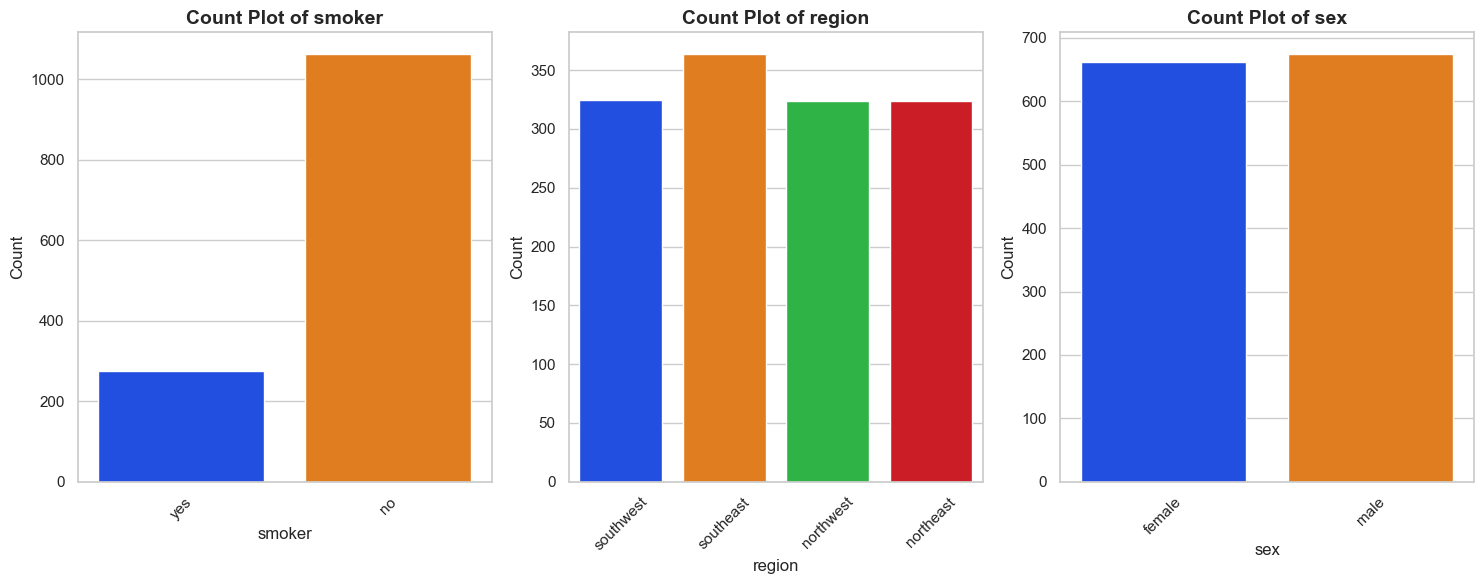

06/02/2025 15:44:28 : INFO : Check van categorische features


In [18]:
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, len(df_cat_col) * 2))  

for i, col in enumerate(df_cat_col):
    plt.subplot(1, len(df_cat_col), i + 1)
    sns.countplot(x=col, data=df, palette='bright')
    plt.title(f"Count Plot of {col}", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
save_fig("Categorische features countplot")
plt.show()
log_info("Check van categorische features")

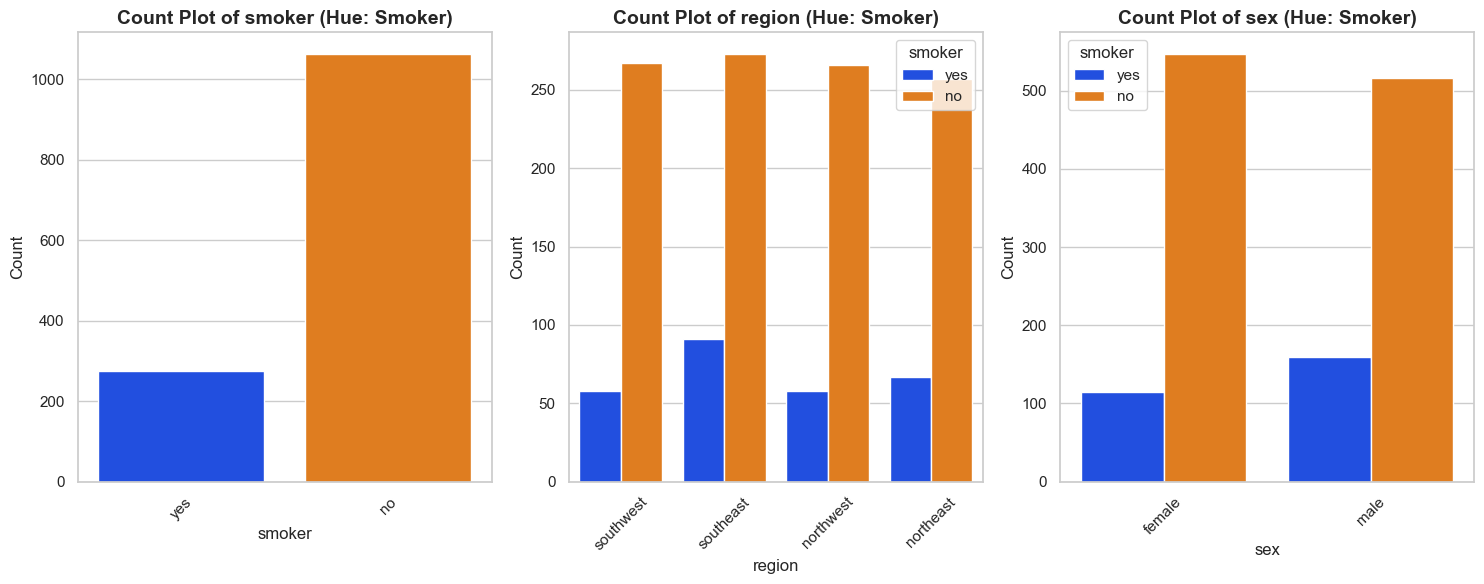

In [19]:
sns.set_theme(style="whitegrid", palette="bright")
plt.figure(figsize=(15, len(df_cat_col) * 2))  

for i, col in enumerate(df_cat_col):
    plt.subplot(1, len(df_cat_col), i + 1)
    sns.countplot(x=col, data=df, palette='bright', hue='smoker')
    plt.title(f"Count Plot of {col} (Hue: Smoker)", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
save_fig("Categorische variabelen tov smoker")
plt.show()

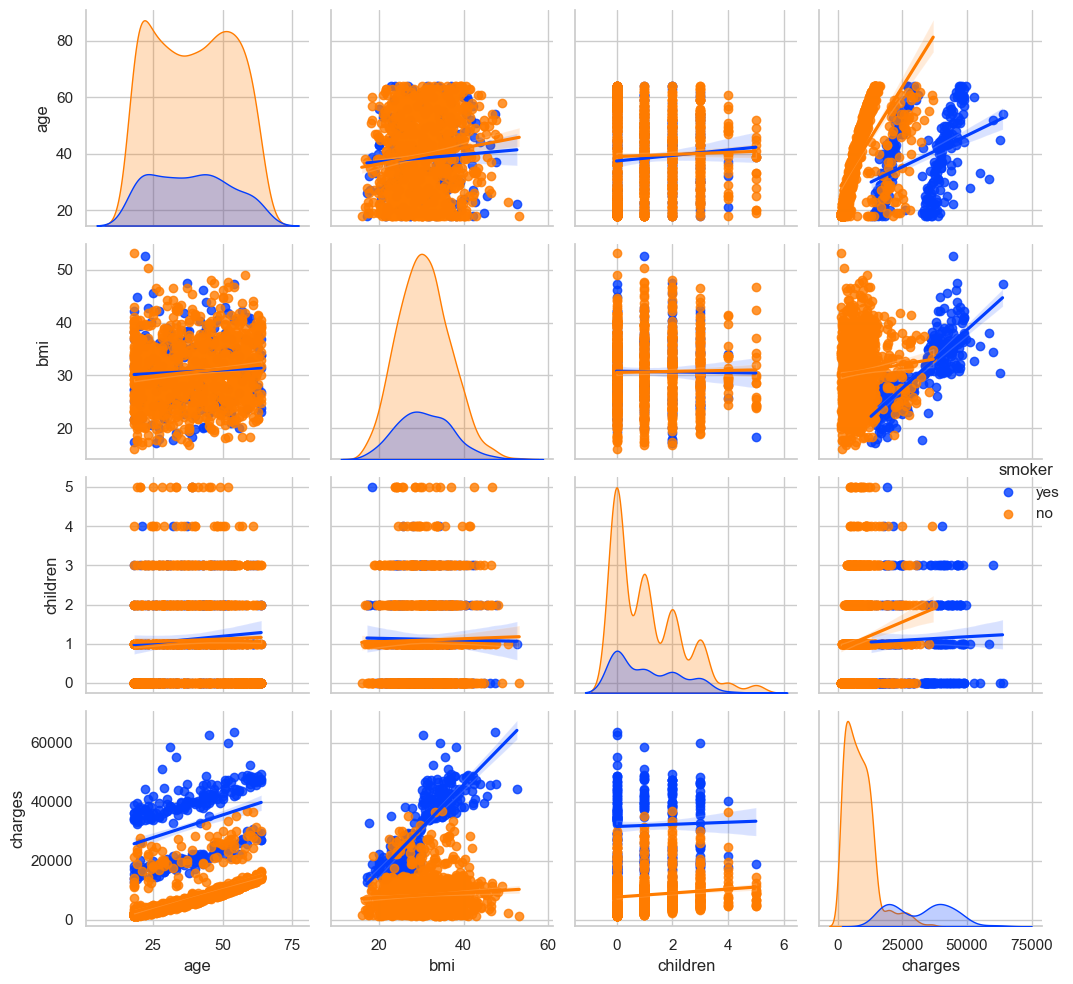

In [15]:
sns.pairplot(df, hue='smoker', palette='bright', kind='reg')
plt.tight_layout()
save_fig("Numerische features onderlinge scatter")
plt.show()

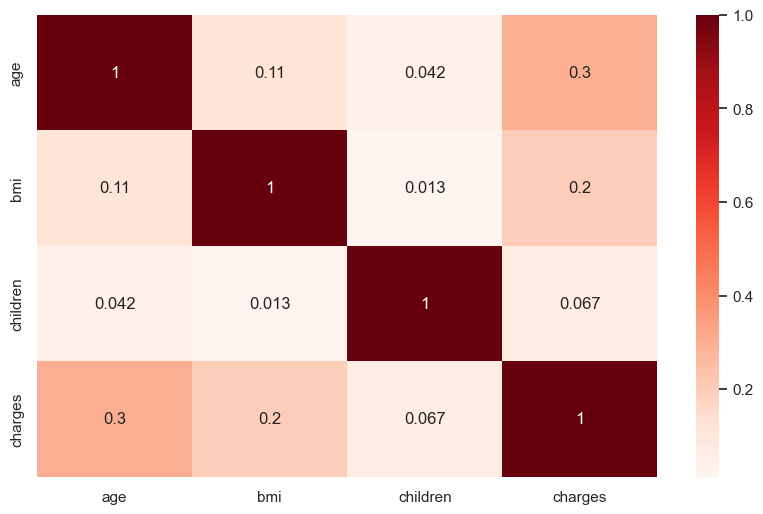

In [20]:
# print de correlation nog af tussen de numerische waarden

plt.figure(figsize=(10, 6))
sns.heatmap(df[df_num_col].corr(), annot=True, cmap='Reds')
save_fig("Numerische features correlatie")
plt.show()

In [ ]:
# outliers bepalen en vervangen door de percentieel ondergrens of bovengrens

from sklearn.ensemble import IsolationForest

# Veronderstel dat 'df' je DataFrame is
# Initialiseren van het Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit het model
iso_forest.fit(df[['bmi','charges']])

# Voorspellingen
# Het geeft -1 voor outliers en 1 voor inliers
labels = iso_forest.predict(df[['bmi','charges']])
# Toevoegen van de labels aan het DataFrame om outliers te identificeren
df['outlier'] = labels
outliers = df[df['outlier'] == -1]
df['outlier'].value_counts()
# er zijn wel wat outliers...
# we gaan ze moeten oplossen
# we zullen dit doen via Capping (Winsorizing)

def cap_values(df, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    
    # Waarden cappen met behulp van de numpy.where functie
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# DataFrame en kolom aanpassen
df_adjusted = cap_values(df, 'column')

NOG NIET GETEST






outlier
 1    980
-1    357
Name: count, dtype: int64